In [1]:
import jax
jax.config.update("jax_enable_x64", True)
from flax import linen as nn
import jax.numpy as jnp
from typing import Callable, Sequence
from jaxtyping import Array, Complex, Float
import specq_dev.specq.shared as specq
import optax
from torch.utils.data import DataLoader, Dataset
import numpy as np

from core import (
    Wo_2_level,
    calculate_exp,
    get_simulator,
    SpecQDataset,
    mse,
    batch_mse,
    batched_calculate_expectation_value,
    loss as loss_fn,
    create_train_step,
    calculate_expvals,
    plot_expvals,
    gate_fidelity
)
from pulse import get_drag_pulse_sequence
import logging
import matplotlib.pyplot as plt

## Model Definition

In [2]:
class BasicBlackBox(nn.Module):
    feature_size: int
    hidden_sizes_1: Sequence[int] = (20, 10)
    hidden_sizes_2: Sequence[int] = (20, 10)
    pauli_operators: Sequence[str] = ("X", "Y", "Z")

    activation: Callable = nn.tanh
    NUM_UNITARY_PARAMS: int = 3
    NUM_DIAGONAL_PARAMS: int = 2

    @nn.compact
    def __call__(self, x: jnp.ndarray):
        x = nn.Dense(features=self.feature_size)(x)
        # Flatten the input
        x = x.reshape((x.shape[0], -1))
        # Apply a activation function
        x = nn.relu(x)
        # Dropout
        # x = nn.Dropout(0.2)(x)
        # Apply a dense layer for each hidden size
        for hidden_size in self.hidden_sizes_1:
            x = nn.Dense(features=hidden_size)(x)
            x = nn.relu(x)

        Wos_params = dict()
        for op in self.pauli_operators:
            # Sub hidden layer
            for hidden_size in self.hidden_sizes_2:
                _x = nn.Dense(features=hidden_size)(x)
                _x = nn.relu(_x)

            Wos_params[op] = dict()
            # For the unitary part, we use a dense layer with 3 features
            unitary_params = nn.Dense(features=self.NUM_UNITARY_PARAMS)(_x)
            # Apply sigmoid to this layer
            unitary_params = 2 * jnp.pi * nn.sigmoid(unitary_params)
            # For the diagonal part, we use a dense layer with 1 feature
            diag_params = nn.Dense(features=self.NUM_DIAGONAL_PARAMS)(_x)
            # Apply the activation function
            diag_params = self.activation(diag_params)

            Wos_params[op] = {
                "U": unitary_params,
                "D": diag_params,
            }

        return Wos_params

In [ ]:

class GRUBlackBox(nn.Module):

    def setup(self) -> None:
        
        condense_layer = [
            nn.Dense(10),
            nn.relu,
            nn.Dense(5),
            nn.relu,
        ]

    def __call__(self, x: jnp.ndarray):
        
        output_auto_1 = ...
        
        return 

In [ ]:
# temp_model = nn.Dense(5)
model_key, pulse_key = jax.random.split(jax.random.PRNGKey(0))
temp_model = BasicBlackBox(feature_size=10)

temp_pulse_params = jax.random.uniform(pulse_key, (3, 30))

params = temp_model.init(model_key, temp_pulse_params)

out = temp_model.apply(params, temp_pulse_params)
# out.shape, out

In [ ]:
out

## Test model with dummies data

In [ ]:
def create_dummy_data(
    key: jnp.ndarray,
    batch_size: int,
    pulse_params_shape: Sequence[int],
) -> tuple[
    jnp.ndarray,
    jnp.ndarray,
    jnp.ndarray,
]:
    DIMENSION = 2

    # Split the key
    unitaries_key, pulse_parameters_key, expectations_value_key = jax.random.split(
        key, 3 # <--- 3 keys
    )

    real_key, imag_key = jax.random.split(unitaries_key)

    # Random the unitary operators
    unitaries = jax.random.normal(
        real_key, (batch_size, DIMENSION, DIMENSION)
    ) + 1j * jax.random.normal(imag_key, (batch_size, DIMENSION, DIMENSION))
    # Normalize the unitaries
    unitaries = jnp.array([jnp.linalg.qr(unitary)[0] for unitary in unitaries])

    # Random the pulse parameters
    pulse_parameters = jax.random.normal(
        pulse_parameters_key, (batch_size, *pulse_params_shape)
    )
    # Random the expectation values
    expectations = jax.random.normal(
        expectations_value_key, (batch_size, len(specq.default_expectation_values))
    )
    return pulse_parameters, unitaries, expectations

In [ ]:
model_class = BasicBlackBox

### Pulse sequence with 2 dimensions shape

In [ ]:
model_key, subkey = jax.random.split(jax.random.PRNGKey(0))
batch_size = 10
num_pulses = 80
feature_size = 2
shape = (num_pulses, feature_size)

# initialize the model
model = model_class(feature_size=feature_size)
params = model.init(model_key, jnp.ones((batch_size, *shape)))

pulse_parameters, unitaries, expectations = create_dummy_data(
    subkey, batch_size, shape
)

y_pred = loss_fn(params, pulse_parameters, unitaries, expectations, model)
y_pred

### Pulse sequence with 1 dimension shape

In [ ]:
model_key, subkey = jax.random.split(jax.random.PRNGKey(0))
batch_size = 10
shape = (30, )

# initialize the model
model = model_class(feature_size=feature_size)
params = model.init(model_key, jnp.ones((batch_size, *shape)))

pulse_parameters, unitaries, expectations = create_dummy_data(
    subkey, batch_size, shape
)

y_pred = loss_fn(params, pulse_parameters, unitaries, expectations, model)
y_pred

## Load the data

In [3]:
def get_exp_data():
    # Load the data from the experiment
    exp_data = specq.ExperimentDataV3.from_folder("../specq-experiment/datasets/0019")

    print(f"Loaded data from {exp_data.experiment_config.EXPERIMENT_IDENTIFIER}")

    # Setup the simulator
    dt = exp_data.experiment_config.device_cycle_time_ns
    qubit_info = exp_data.experiment_config.qubits[0]
    pulse_sequence = get_drag_pulse_sequence(dt=dt, drive_str=qubit_info.drive_strength)
    t_eval = jnp.linspace(
        0, pulse_sequence.pulse_length_dt * dt, pulse_sequence.pulse_length_dt
    )
    simulator = get_simulator(qubit_info=qubit_info, t_eval=t_eval)

    # The properties of the pulse parameters
    num_pulses = 80
    feature_size = 2

    # Get the waveforms for each pulse parameters to get the unitaries
    waveforms = []
    for pulse_params in exp_data.get_parameters_dict_list():
        waveforms.append(pulse_sequence.get_waveform(pulse_params))

    waveforms = jnp.array(waveforms)

    print(
        f"Prepared the waveforms for the experiment {exp_data.experiment_config.EXPERIMENT_IDENTIFIER}"
    )

    # jit the simulator
    jitted_simulator = jax.jit(simulator)
    # batch the simulator
    batched_simulator = jax.vmap(jitted_simulator, in_axes=(0))
    # Get the unitaries
    unitaries = batched_simulator(waveforms)

    print(
        f"Got the unitaries for the experiment {exp_data.experiment_config.EXPERIMENT_IDENTIFIER}"
    )

    # Get the final unitaries
    unitaries = np.array(unitaries[:, -1, :, :])
    # Get the expectation values from the experiment
    expectations = exp_data.get_expectation_values()
    # Get the pulse parameters
    pulse_parameters = exp_data.parameters.reshape(
        (exp_data.parameters.shape[0], num_pulses, feature_size)
    )

    print(
        f"Finished preparing the data for the experiment {exp_data.experiment_config.EXPERIMENT_IDENTIFIER}"
    )

    return pulse_parameters, unitaries, expectations, pulse_sequence, simulator

pulse_parameters, unitaries, expectations, pulse_sequence, simulator = get_exp_data()

Loaded data from 0019
Prepared the waveforms for the experiment 0019
Got the unitaries for the experiment 0019
Finished preparing the data for the experiment 0019


In [4]:
# Final goal of setting up is to create a dataset and a dataloader
dataset = SpecQDataset(
    pulse_parameters=pulse_parameters.reshape(-1, 160),
    unitaries=unitaries,
    expectation_values=expectations,
)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## Train the model

In [5]:
key, model_key = jax.random.split(jax.random.PRNGKey(0))
model = BasicBlackBox(feature_size=30)
# optimiser = optax.adam(learning_rate=1e-3)

warmup_start_lr, warmup_steps = 1e-6, 100
start_lr, end_lr, steps = 1e-2, 1e-5, 1_000
lr_scheduler = optax.join_schedules(
    [
        optax.linear_schedule(
            warmup_start_lr,
            start_lr,
            warmup_steps,
        ),
        optax.linear_schedule(
            start_lr,
            end_lr,
            steps - warmup_steps,
        ),
    ],
    [warmup_steps],
)

optimiser = optax.adam(lr_scheduler)

train_step, test_step, model_params, opt_state = create_train_step(
    key=model_key,
    model=model,
    optimiser=optimiser,
    loss_fn=lambda params, pulse_parameters, unitaries, expectations: loss_fn(
        params, pulse_parameters, unitaries, expectations, model
    ),
    input_shape=(128, 160),
)

In [6]:
freq = 5
for epoch in range(1000):
    total_loss = 0.0
    for i, batch in enumerate(dataloader):
        
        _pulse_parameters = batch["x0"].numpy()
        _unitaries = batch["x1"].numpy()
        _expectations = batch["y"].numpy()

        model_params, opt_state, loss = train_step(model_params, opt_state, _pulse_parameters, _unitaries, _expectations)

        total_loss += loss

        print(f"epoch {epoch} | step {i} | loss: {total_loss / freq}")

/Users/porametpathumsoot/miniconda3/envs/specq-dev/lib/python3.12/site-packages/jax/_src/lax/lax.py:2660: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


epoch 0 | step 0 | loss: 0.061516014259857886
epoch 0 | step 1 | loss: 0.12314624096146236
epoch 0 | step 2 | loss: 0.18465948641019098
epoch 0 | step 3 | loss: 0.24613037899659868
epoch 0 | step 4 | loss: 0.30754691616074714
epoch 0 | step 5 | loss: 0.36885490427168516
epoch 0 | step 6 | loss: 0.4299714766956235
epoch 0 | step 7 | loss: 0.49081072386840574
epoch 0 | step 8 | loss: 0.5515428817070159
epoch 0 | step 9 | loss: 0.6119762747867009
epoch 0 | step 10 | loss: 0.6722495453148655
epoch 0 | step 11 | loss: 0.73225741033545
epoch 1 | step 0 | loss: 0.05947775735225382
epoch 1 | step 1 | loss: 0.1184938978200322
epoch 1 | step 2 | loss: 0.17697231369423022
epoch 1 | step 3 | loss: 0.2348560807267437
epoch 1 | step 4 | loss: 0.2920519896189518
epoch 1 | step 5 | loss: 0.3487333446482862
epoch 1 | step 6 | loss: 0.40458284205104594
epoch 1 | step 7 | loss: 0.45955343364057877
epoch 1 | step 8 | loss: 0.5136923008436229
epoch 1 | step 9 | loss: 0.5666690805067022
epoch 1 | step 10 | 

## Evaluate the model

In [7]:
test_out = model.apply(model_params, _pulse_parameters[:5])
test_out

{'X': {'U': Array([[3.73226933, 4.05474459, 2.63021372],
         [3.68750149, 4.00503233, 2.75178667],
         [3.61604906, 3.90828079, 2.76443914],
         [3.57998813, 3.89382677, 2.76589543],
         [3.60015026, 4.02776351, 2.60074799]], dtype=float64),
  'D': Array([[ 0.97739975, -0.96378737],
         [ 0.96928637, -0.96483688],
         [ 0.96360744, -0.94448443],
         [ 0.96407468, -0.94210232],
         [ 0.97535586, -0.95301118]], dtype=float64)},
 'Y': {'U': Array([[3.13014621, 3.76144292, 1.65054678],
         [3.18739323, 3.8081313 , 1.86559491],
         [2.87538439, 3.78014599, 1.84613854],
         [2.86750494, 3.78851834, 1.89684213],
         [3.02375846, 3.80736038, 1.71132905]], dtype=float64),
  'D': Array([[ 0.98018032, -0.9674017 ],
         [ 0.9728488 , -0.94090151],
         [ 0.9679564 , -0.95663107],
         [ 0.96319901, -0.94365806],
         [ 0.97502298, -0.95996603]], dtype=float64)},
 'Z': {'U': Array([[1.91569763, 2.99089409, 2.02792776],
   

## Predict the gate

In [17]:
from jax.scipy.optimize import minimize
from core import gate_loss, X, Y, Z

In [9]:
# Evaluate the gate loss to test the function
gate_loss(
    jnp.array(pulse_parameters[0]).flatten(),
    model,
    model_params,
    simulator,
    pulse_sequence,
    X,
)

Array(0.01586717, dtype=float64)

In [10]:
key = jax.random.PRNGKey(0)
pulse_params = pulse_sequence.sample_params(key)
x0 = pulse_sequence.list_of_params_to_array(pulse_params)
res = minimize(
    gate_loss,
    x0=jnp.array(x0),
    method="BFGS",
    args=(model, model_params, simulator, pulse_sequence, X),
)
res.fun

/Users/porametpathumsoot/miniconda3/envs/specq-dev/lib/python3.12/site-packages/jax/_src/lax/lax.py:2660: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Array(8.61050063e-05, dtype=float64)

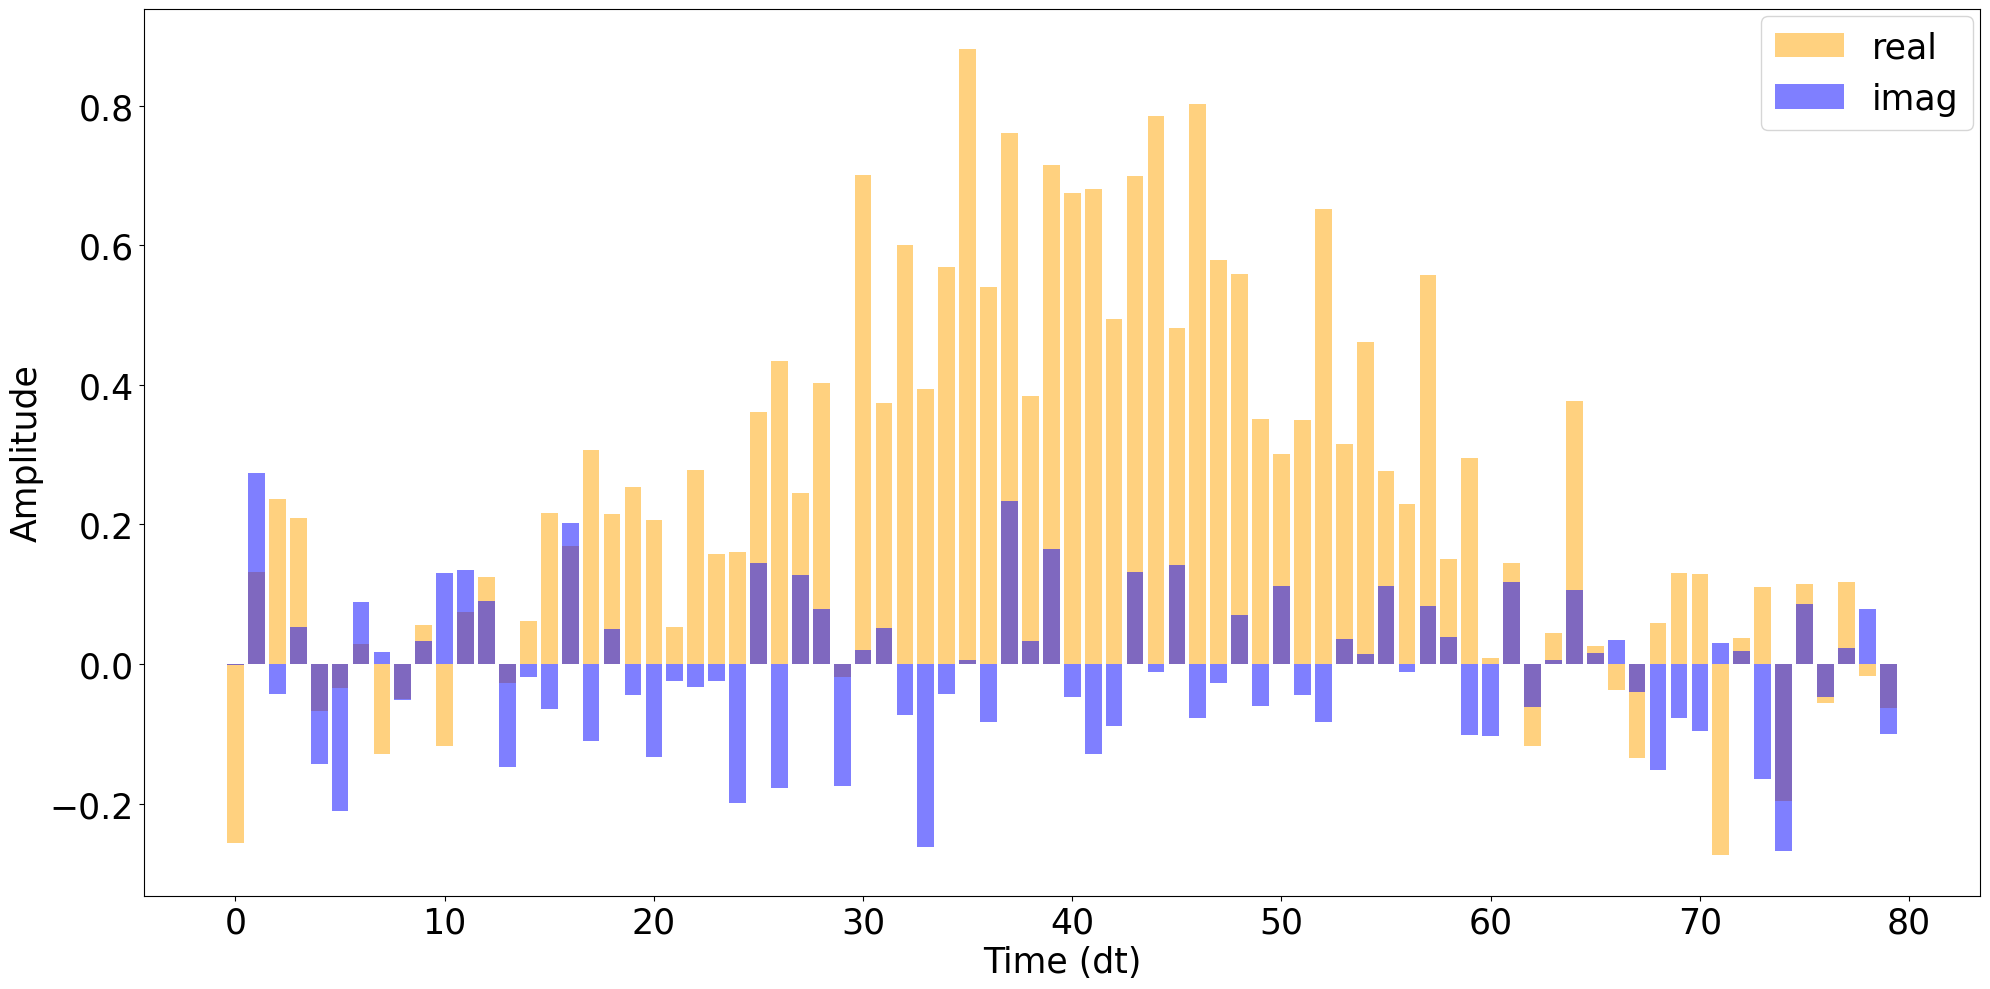

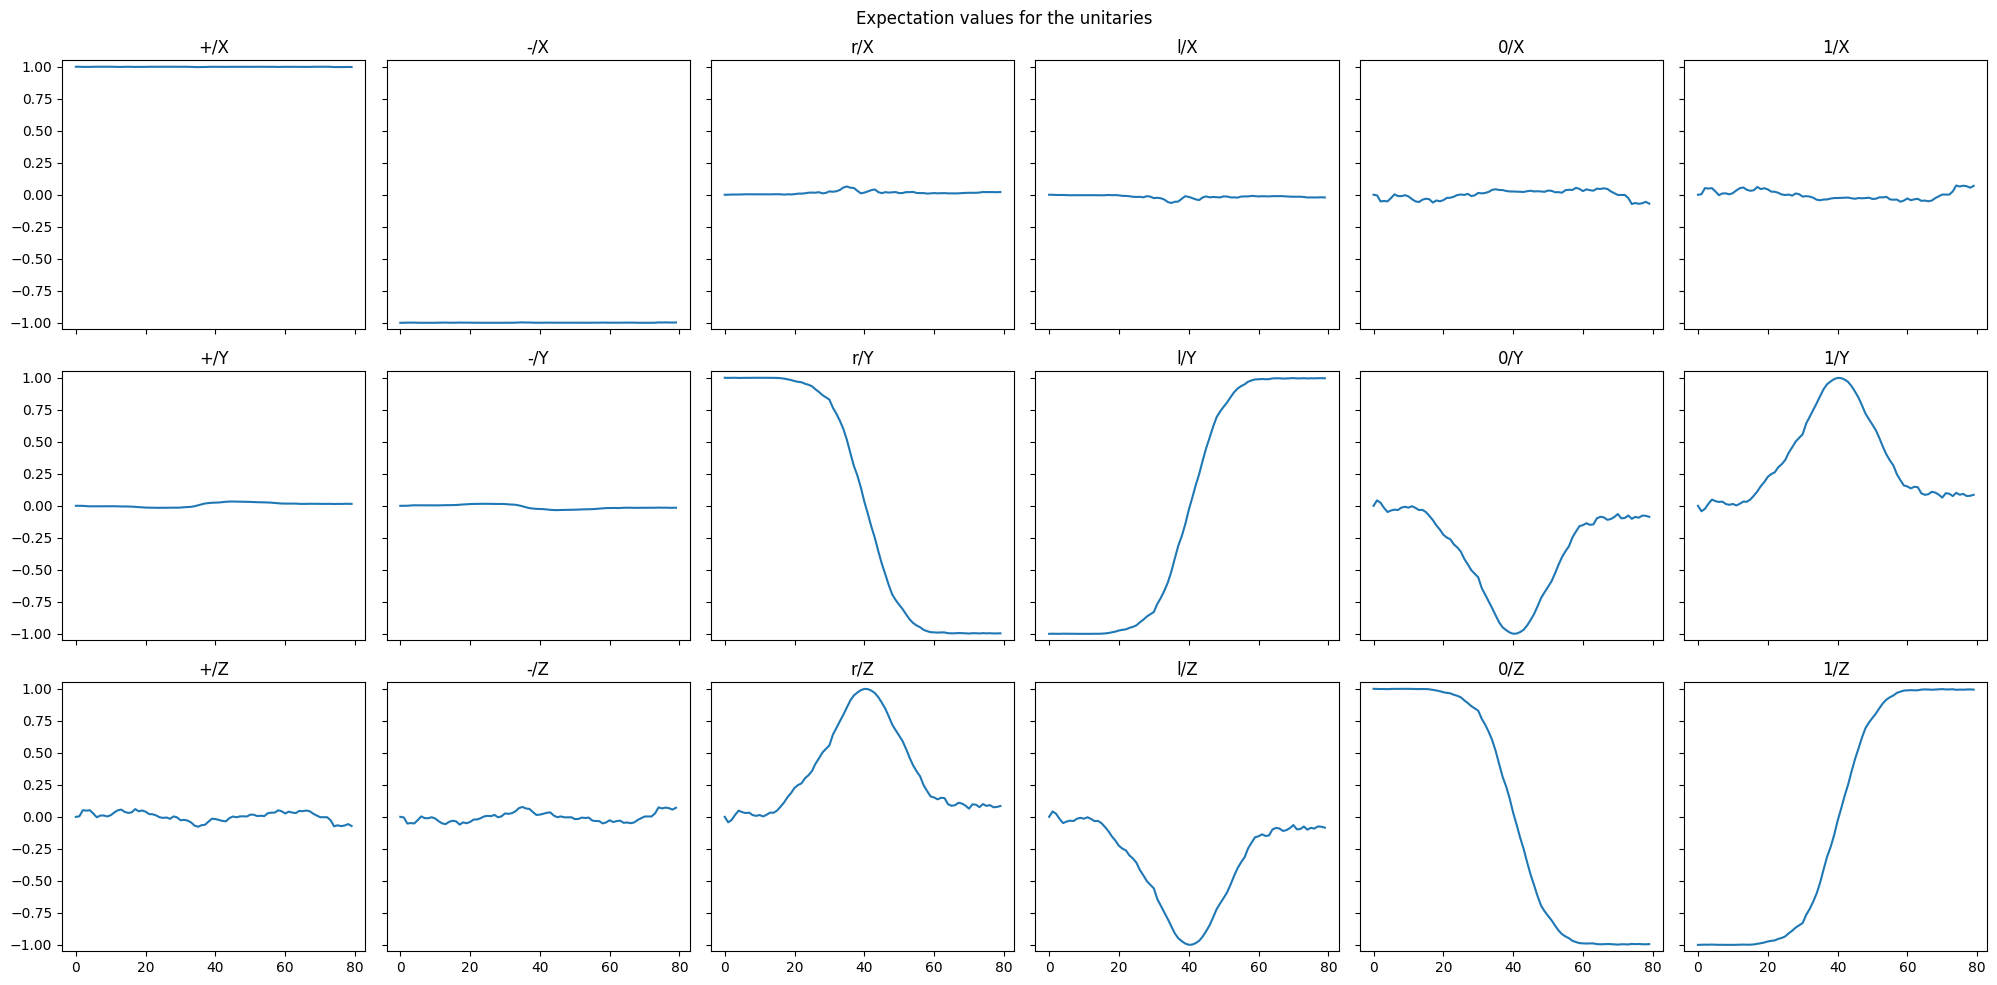

In [11]:
# Plot the optmized result
opt_pulse_params = pulse_sequence.array_to_list_of_params(res.x)
pulse_sequence.draw(opt_pulse_params)

# Calculate the expectation values
waveforms = pulse_sequence.get_waveform(opt_pulse_params)
unitaries = simulator(waveforms)

expvals = calculate_expvals(unitaries)
plot_expvals(expvals)

In [22]:
Wo_params = model.apply(model_params, jnp.expand_dims(res.x, axis=0))
Wo_params = jax.tree_map(lambda x: jnp.squeeze(x, 0), Wo_params)

fidelities = {}
for pauli_str, pauli_op in zip(["X", "Y", "Z"], [X, Y, Z]):
    Wo = Wo_2_level(U=Wo_params[pauli_str]["U"], D=Wo_params[pauli_str]["D"])
    # evaluate the fidleity to the Pauli operator
    fidelities[pauli_str] = gate_fidelity(Wo, pauli_op)

fidelities, gate_fidelity(unitaries[-1], X)

({'X': Array(0.99105151, dtype=float64),
  'Y': Array(0.99019143, dtype=float64),
  'Z': Array(0.99502516, dtype=float64)},
 Array(0.99684331, dtype=float64))